# CAB420 Assignment 1A Question 2: Template

## Overview

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

# load data
train = pd.read_csv('Q2/training.csv')
val = pd.read_csv('Q2/validation.csv')
test = pd.read_csv('Q2/testing.csv')

# pull out X and y data, convert to numpy
X_train = train.iloc[:,1:].to_numpy()
Y_train = train.iloc[:,0].to_numpy()
X_val = val.iloc[:,1:].to_numpy()
Y_val = val.iloc[:,0].to_numpy()
X_test = test.iloc[:,1:].to_numpy()
Y_test = test.iloc[:,0].to_numpy()

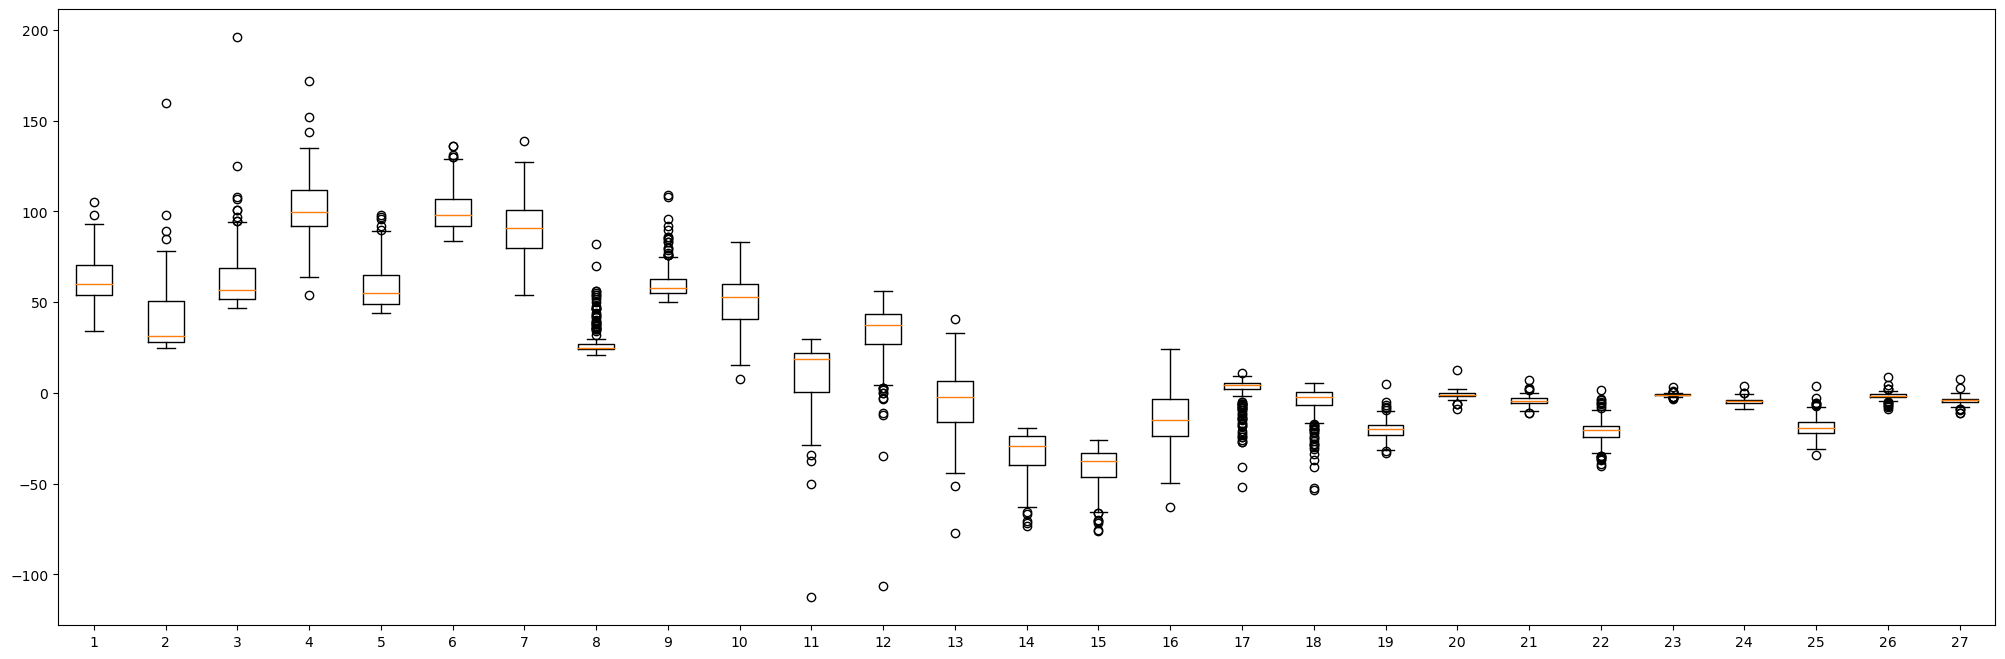

In [2]:
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train);

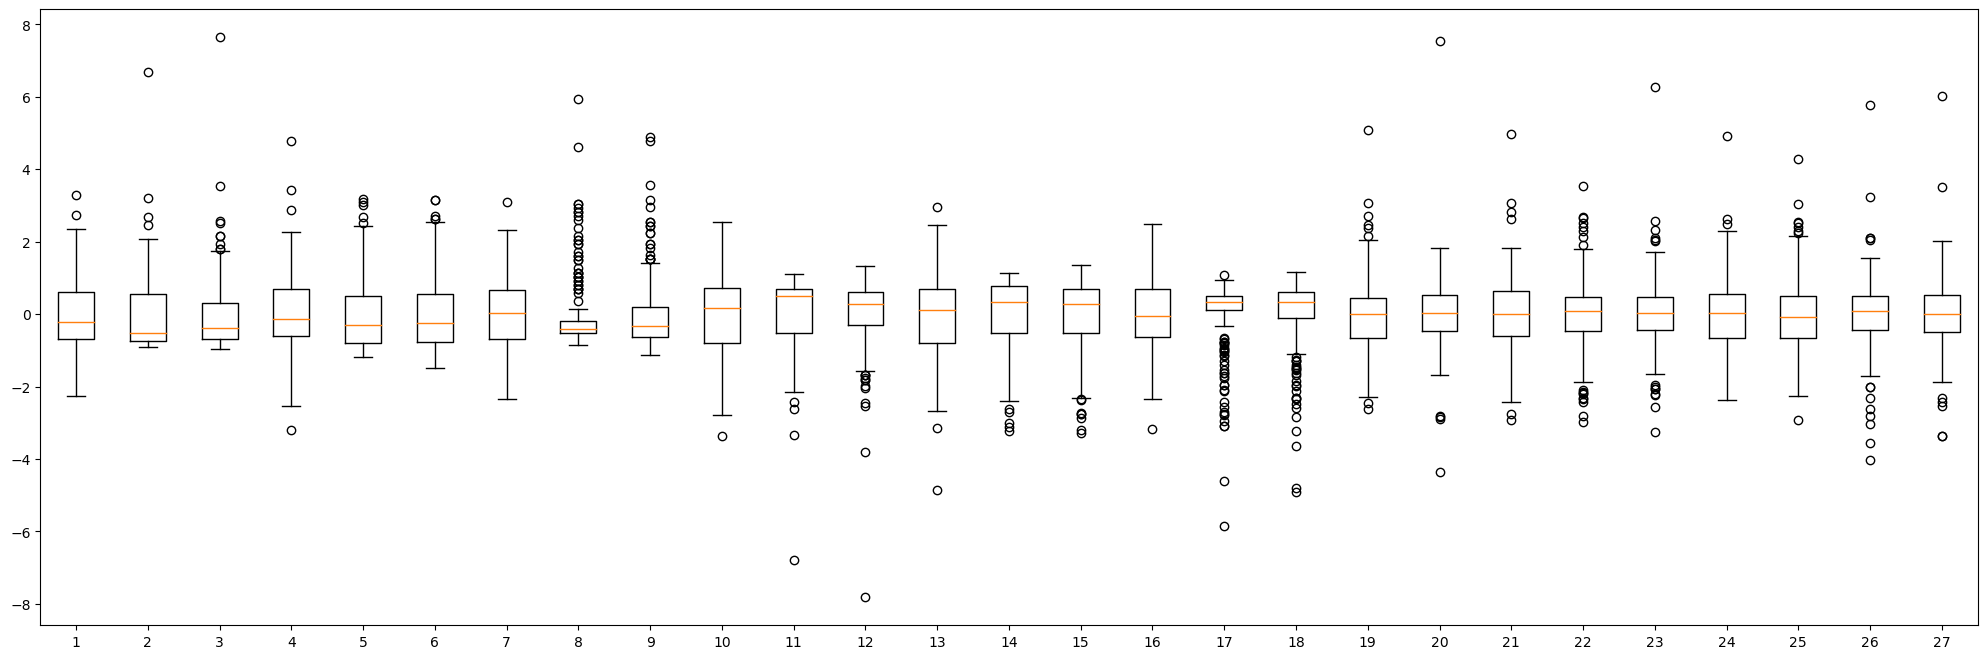

In [3]:
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)

mu = X_train_df.mean()
sigma = X_train_df.std()
X_train_df = (X_train_df - mu) / sigma;
X_test_df = (X_test_df - mu) / sigma;
fig = plt.figure(figsize=[25, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_train_df);

Text(0.5, 1.0, 'Test data set')

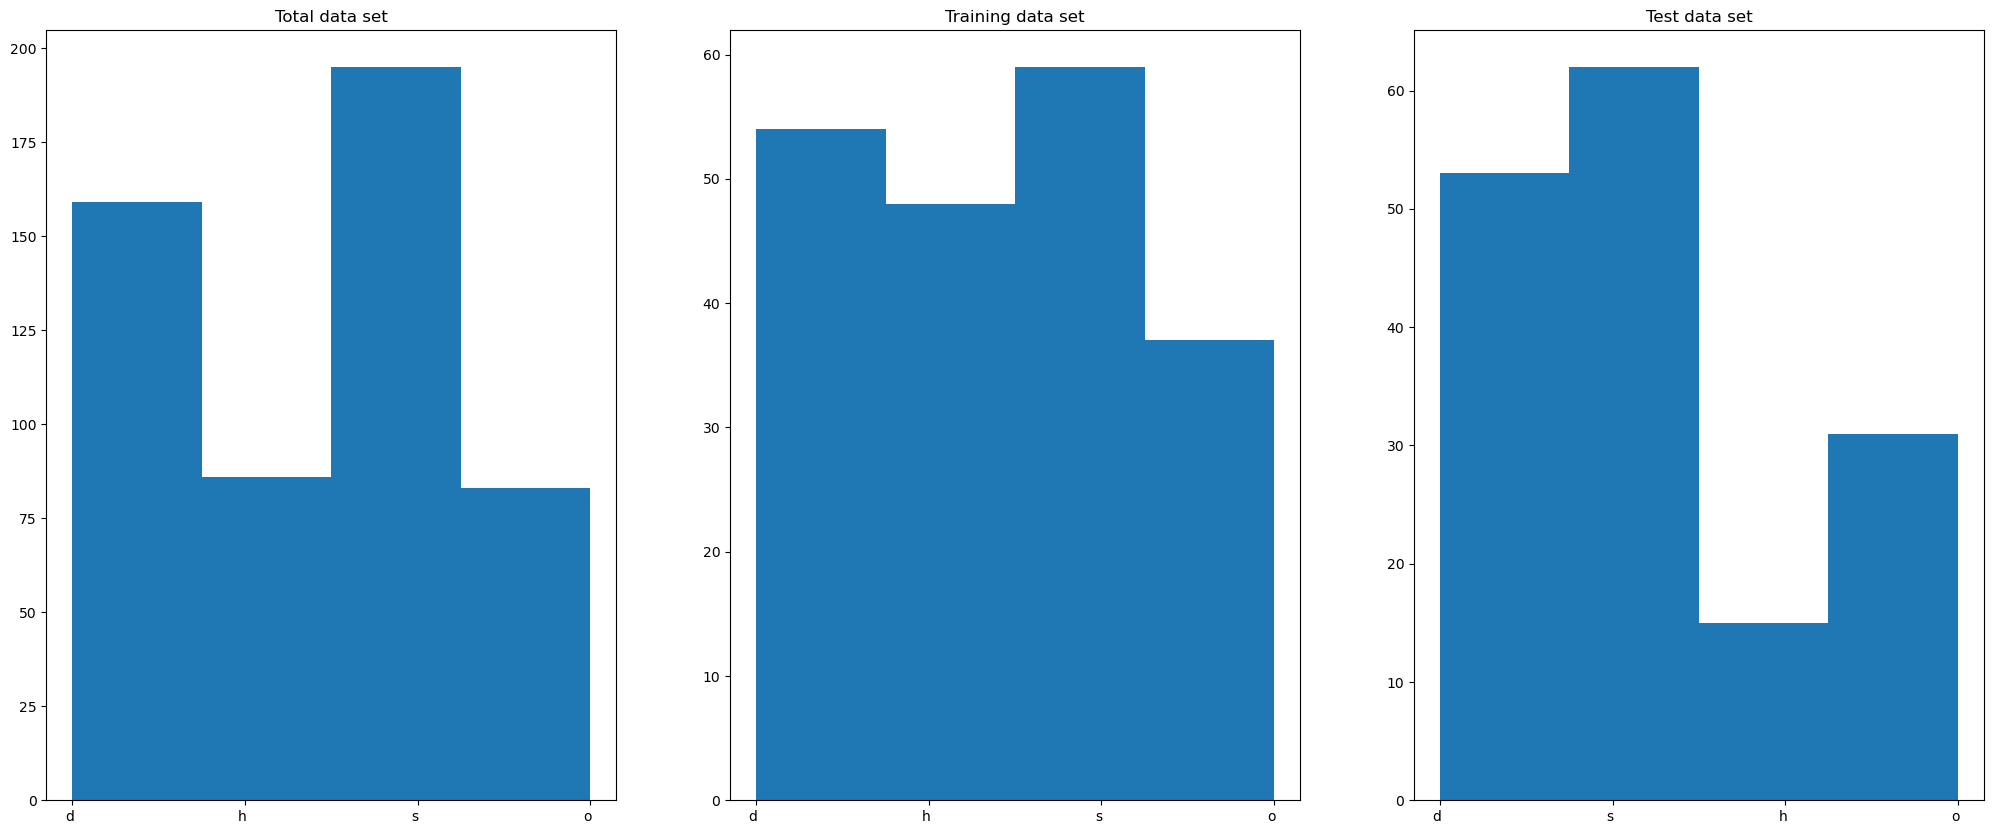

In [4]:
X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()
Y = np.concatenate((Y_train, Y_val, Y_test))
fig = plt.figure(figsize=[25, 10])
ax = fig.add_subplot(1, 3, 1)
ax.hist(Y, 4)
ax.set_title('Total data set')
ax = fig.add_subplot(1, 3, 2)
ax.hist(Y_train, 4)
ax.set_title('Training data set')
ax = fig.add_subplot(1, 3, 3)
ax.hist(Y_test, 4)
ax.set_title('Test data set')

In [5]:
# helper function adapted from lecture examples

# function to do our eval for us, this is quite simple and will
# - create a figure
# - draw a confusion matrix for the trainign data in a sub-fig on the left
# - draw a confusion matrix for the testing data in a sub-fig on the right
# - get precision, recall, f1 for test data
# this has simply been created as we're going to do this for each test that we run
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: %1.3f' % (sum(model.predict(X_train) == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: %1.3f' % (sum(model.predict(X_test) == Y_test)/len(Y_test)));
    print(classification_report(Y_test, model.predict(X_test)))

# Random Forest

First up, we'll try a random forest. Let's go with a simple model first and see what happens.

              precision    recall  f1-score   support

          d        0.82      0.70      0.76        53
          h        0.68      0.87      0.76        15
          o        0.81      0.81      0.81        31
          s        0.82      0.87      0.84        62

    accuracy                           0.80       161
   macro avg       0.78      0.81      0.79       161
weighted avg       0.80      0.80      0.80       161



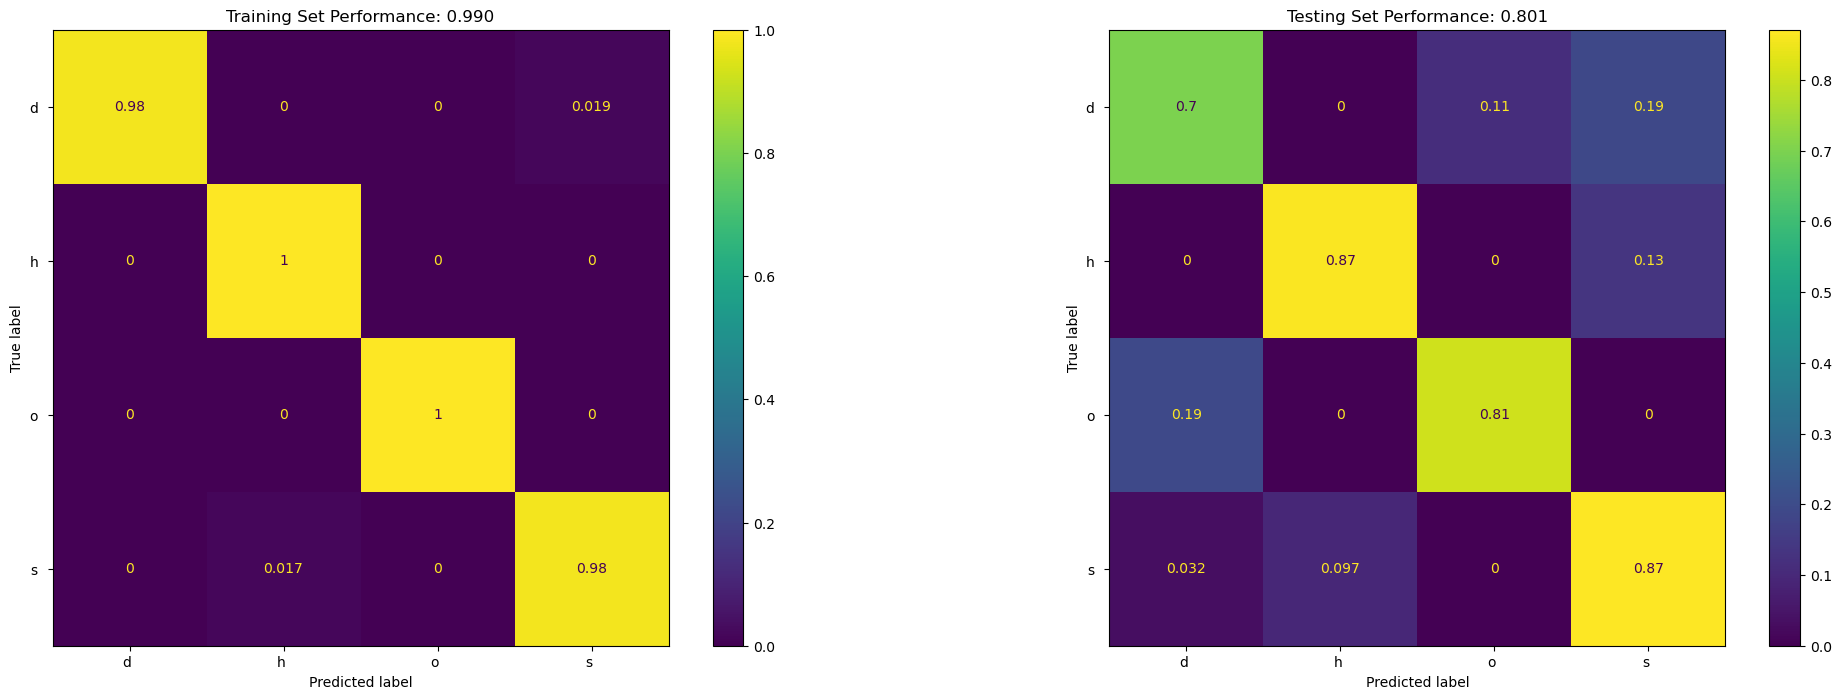

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0).fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

We have some class balance problems. We can try fix this by either:
* making our trees deeper
* setting class weights

Let's try both.

Note that for class weight, I'm going to use 'balanced_subsample' as we have such severe class imbalance and I want to ensure that each individual tree is balanced properly.

              precision    recall  f1-score   support

          d        0.82      0.70      0.76        53
          h        0.68      0.87      0.76        15
          o        0.80      0.77      0.79        31
          s        0.81      0.87      0.84        62

    accuracy                           0.80       161
   macro avg       0.78      0.80      0.79       161
weighted avg       0.80      0.80      0.79       161



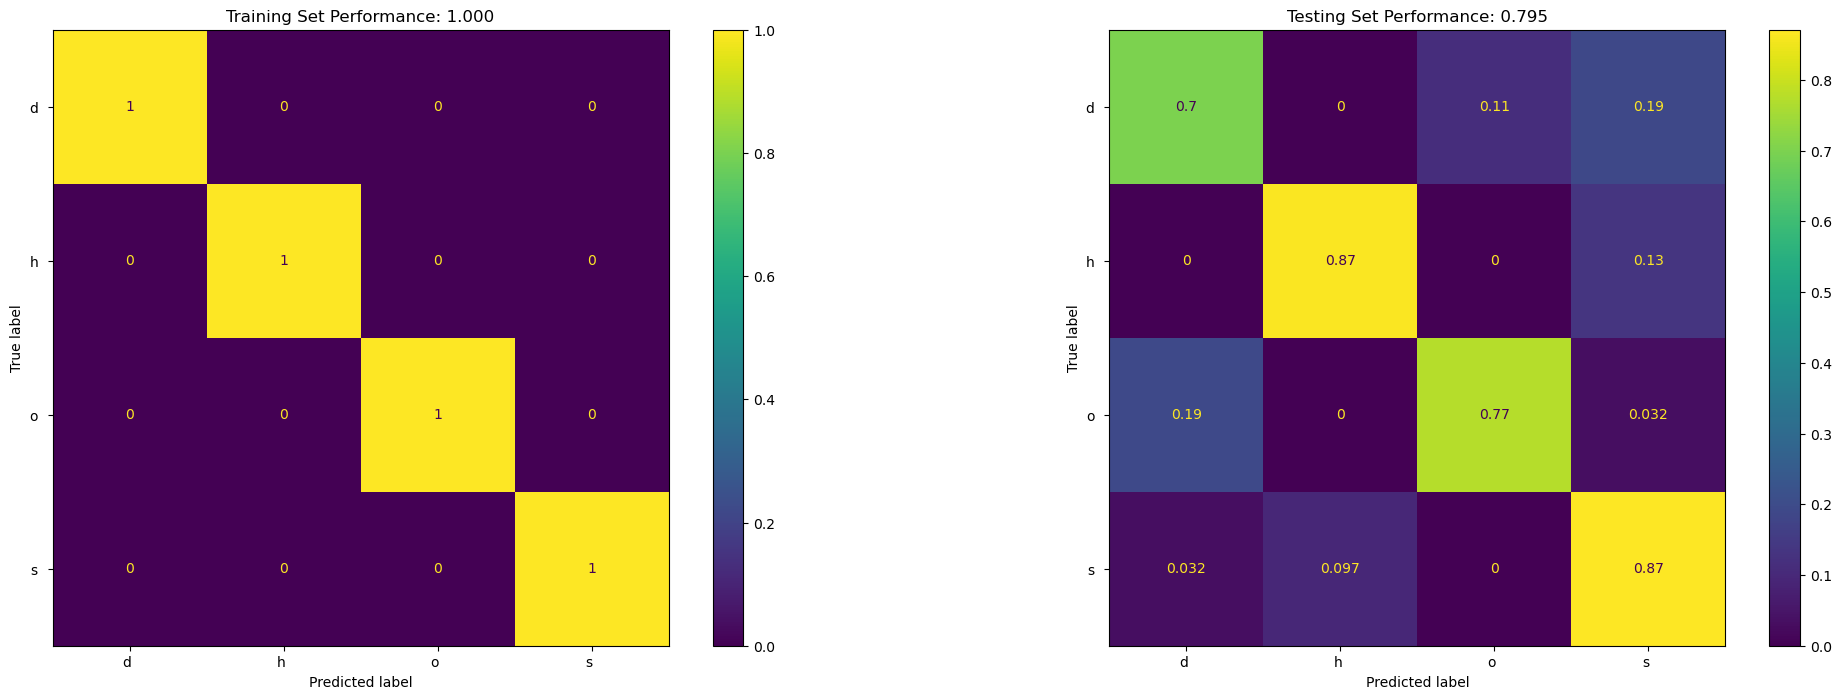

In [7]:
rf = RandomForestClassifier(n_estimators=100, max_depth=32, random_state=0).fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

              precision    recall  f1-score   support

          d        0.81      0.72      0.76        53
          h        0.72      0.87      0.79        15
          o        0.83      0.81      0.82        31
          s        0.82      0.87      0.84        62

    accuracy                           0.81       161
   macro avg       0.80      0.82      0.80       161
weighted avg       0.81      0.81      0.81       161



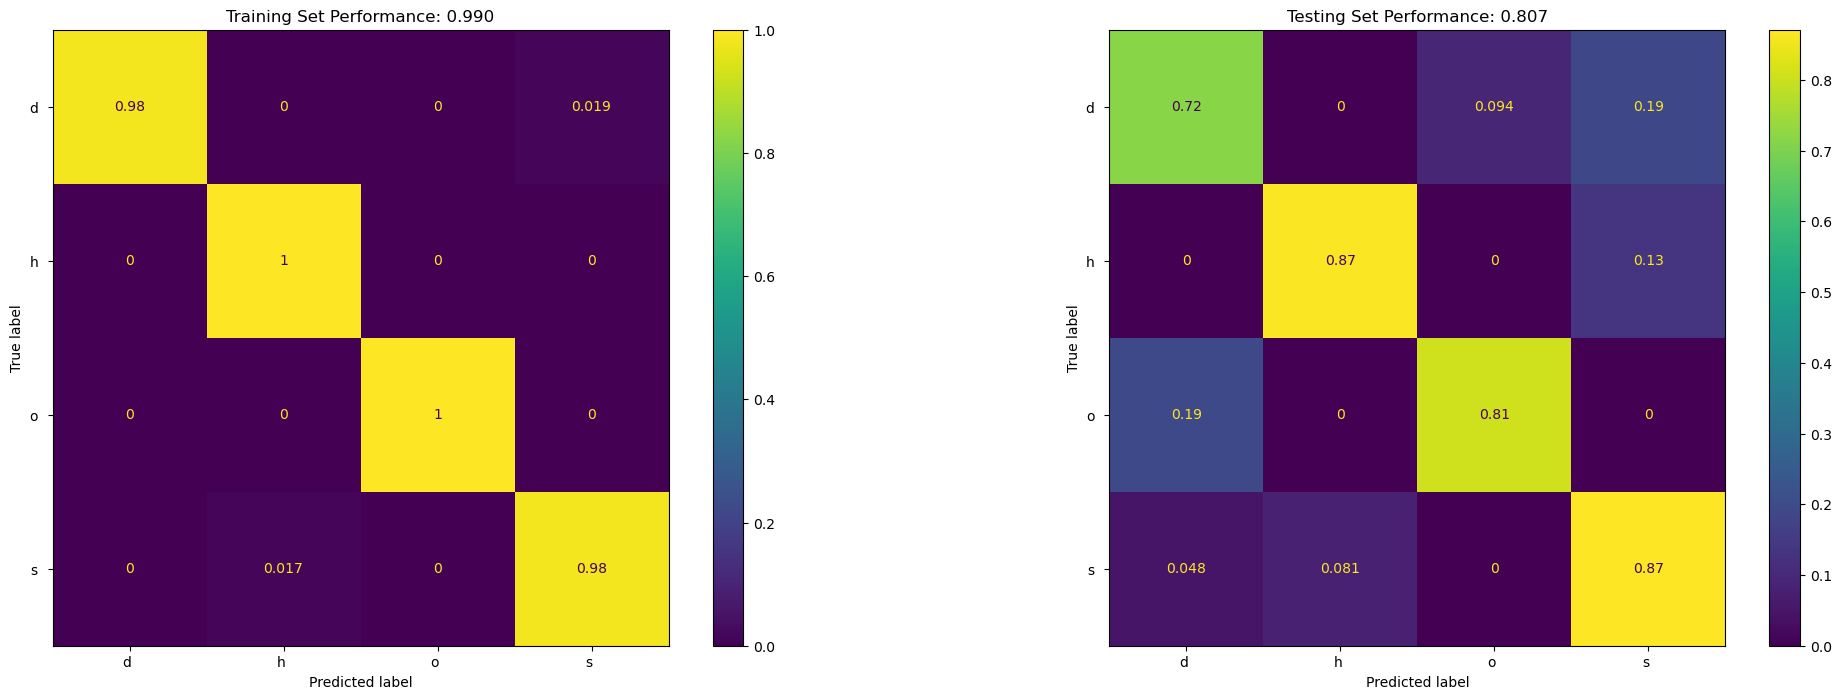

In [8]:
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, class_weight='balanced_subsample').fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

In the end, my deeper tree has massively overfit, while my balanced tree has greatly improved performance on the rare classes, at the cost of the common ones.

If I increase the depth a little bit I can squeeze out some more performance.

              precision    recall  f1-score   support

          d        0.80      0.74      0.76        53
          h        0.68      0.87      0.76        15
          o        0.83      0.77      0.80        31
          s        0.83      0.85      0.84        62

    accuracy                           0.80       161
   macro avg       0.78      0.81      0.79       161
weighted avg       0.80      0.80      0.80       161



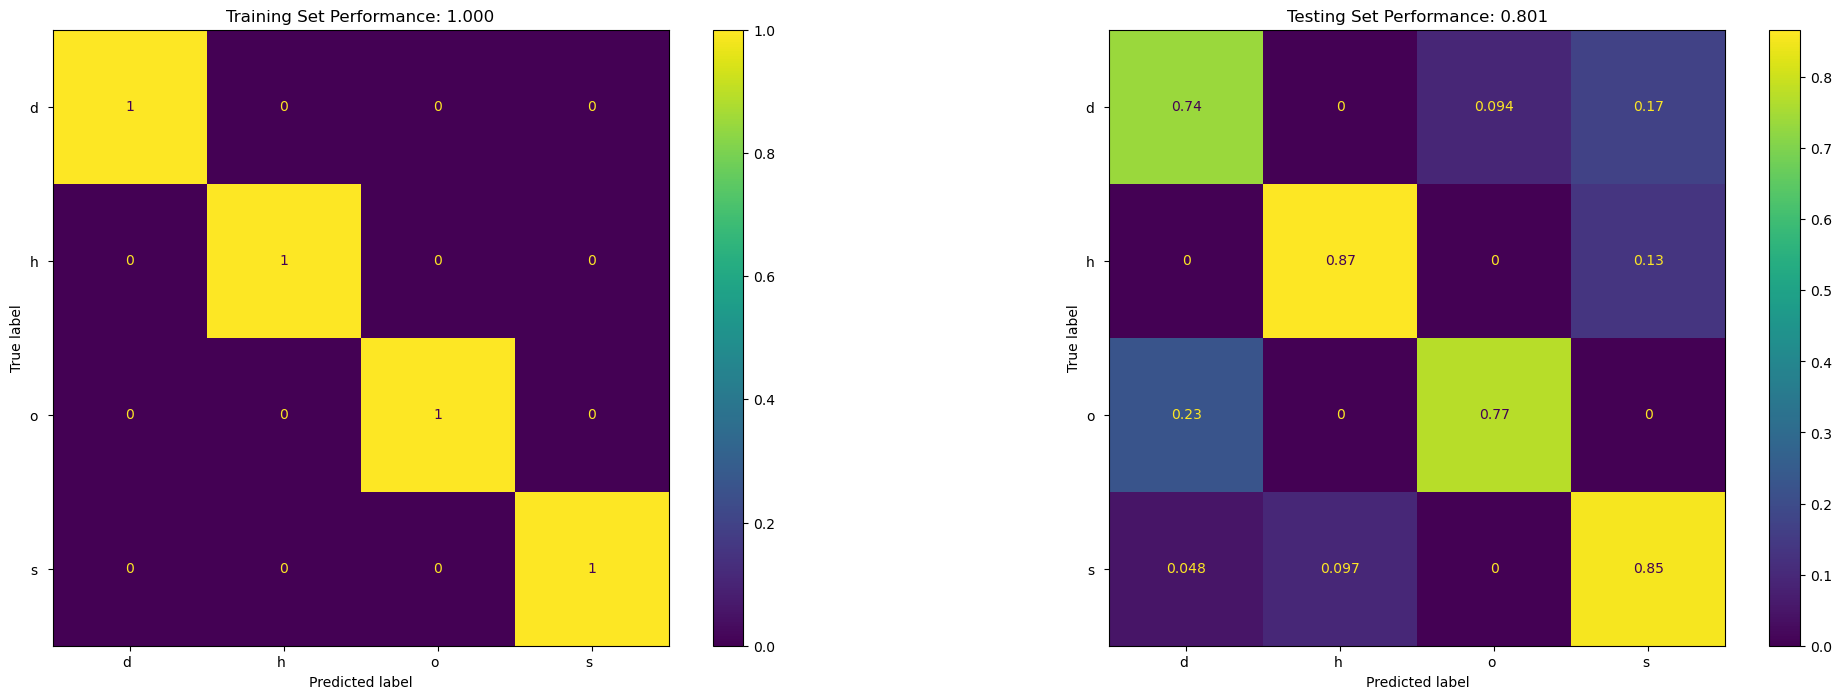

In [9]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0, class_weight='balanced_subsample').fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

As we go deeper, we can improve the test accuracy, but at the cost of the rare classes which we again start to lose.

              precision    recall  f1-score   support

          d        0.80      0.75      0.78        53
          h        0.68      0.87      0.76        15
          o        0.86      0.77      0.81        31
          s        0.83      0.85      0.84        62

    accuracy                           0.81       161
   macro avg       0.79      0.81      0.80       161
weighted avg       0.81      0.81      0.81       161



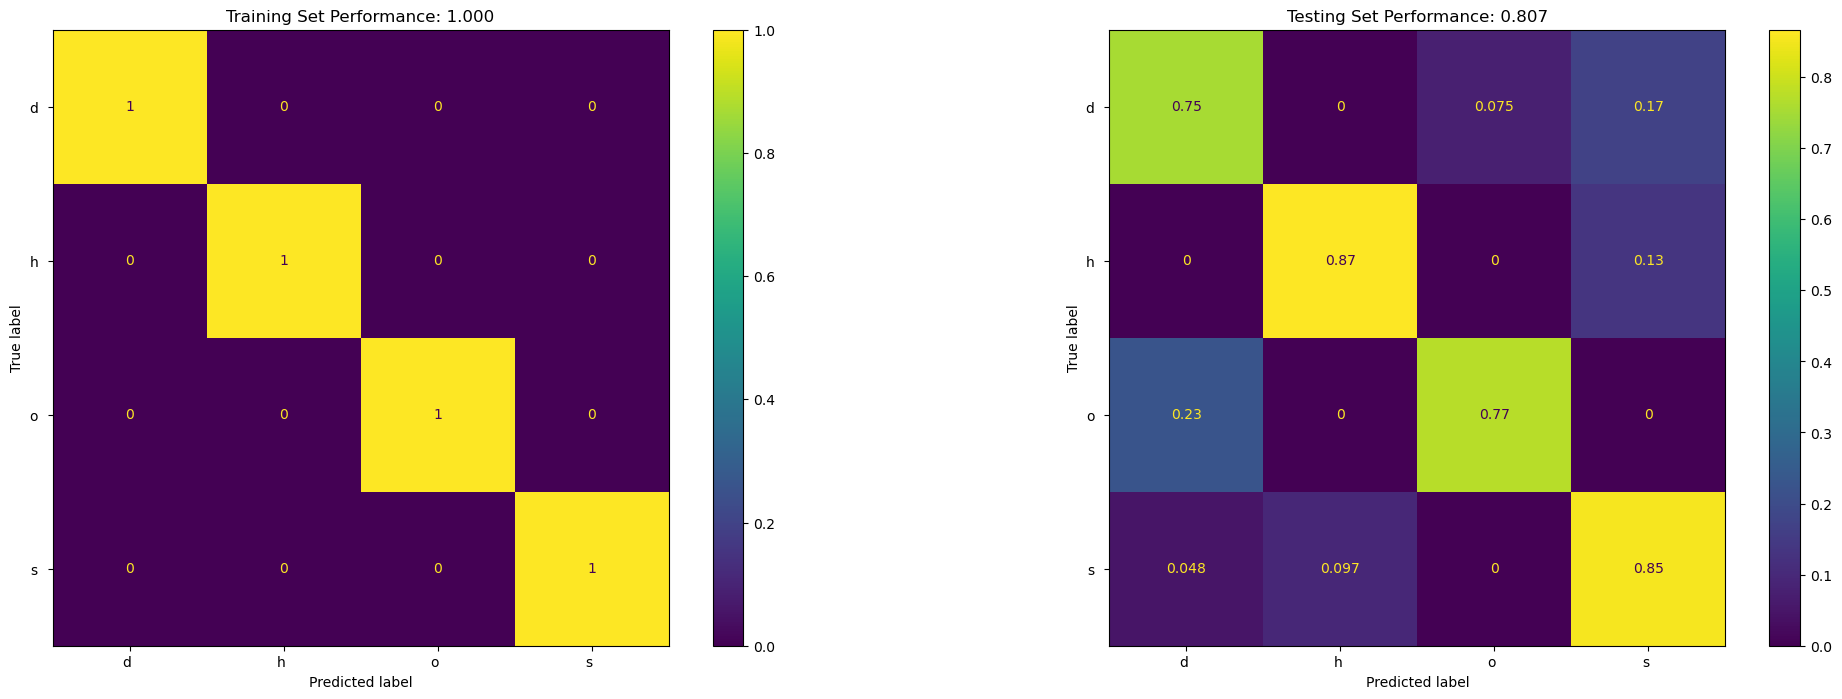

In [10]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=0, class_weight='balanced_subsample').fit(X_train, Y_train)
eval_model(rf, X_train, Y_train, X_test, Y_test)

We could continue to tune these and other parameters and perhaps eek out a bit more performance. One of the challenges however is how we consider our performance. It seems we can maximise performance by ignoring the minority classes - but does this make the model useful? If it can only detect two of the classes then it may have limited utility.

This also highlights a limitation of our accuracy measure. Raw accuracy doesn't really capture a lot of nuance when dealing with a multi-class problems. Thankfully, sklearn has a heap of metrics that we can play with. 

In [11]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

          d        0.80      0.75      0.78        53
          h        0.68      0.87      0.76        15
          o        0.86      0.77      0.81        31
          s        0.83      0.85      0.84        62

    accuracy                           0.81       161
   macro avg       0.79      0.81      0.80       161
weighted avg       0.81      0.81      0.81       161



In [12]:
rf = RandomForestClassifier(random_state=0)
param_grid = { 
    'n_estimators': [25, 50, 100, 200],
    'max_depth' : [1,2,3],
    'class_weight' :['balanced', 'balanced_subsample', None]
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
grid_search = CV_rf.fit(X_val, Y_val)
print(grid_search.best_params_)

{'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 25}


              precision    recall  f1-score   support

          d        0.88      0.85      0.87        53
          h        0.74      0.93      0.82        15
          o        0.96      0.87      0.92        31
          s        0.87      0.89      0.88        62

    accuracy                           0.88       161
   macro avg       0.86      0.89      0.87       161
weighted avg       0.88      0.88      0.88       161



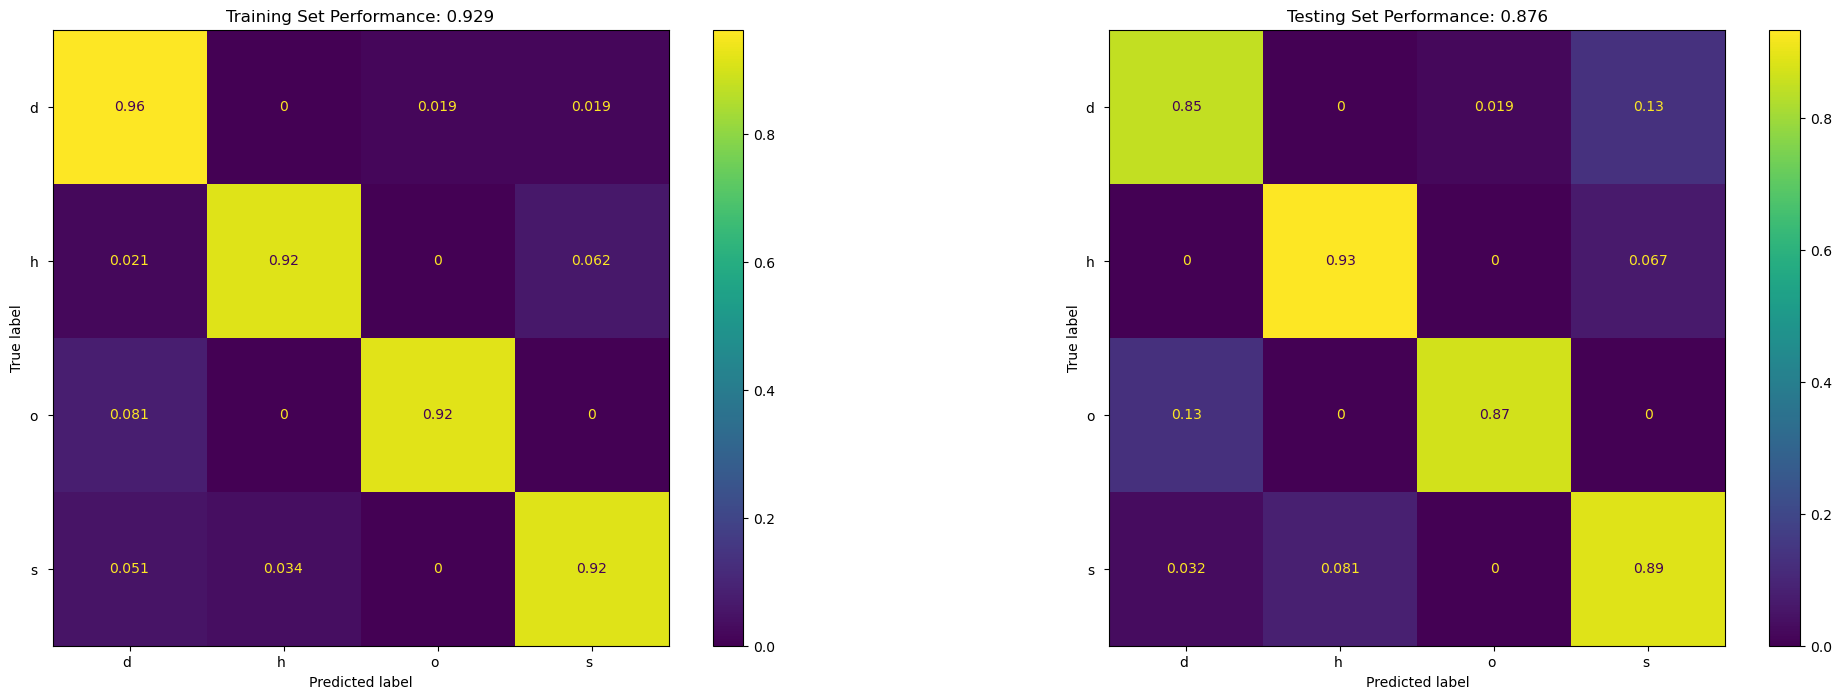

In [13]:
rf = RandomForestClassifier(n_estimators=25, max_depth=3, random_state=0, class_weight='balanced').fit(X_test, Y_test)
eval_model(rf, X_train, Y_train, X_test, Y_test)

We can get a nice little summary which gives more of picture of what's going on. You are encouraged to explore these metrics more in your own time.

# Ensemble of SVMs

## One vs. One

The sklearn SVM class will automatically extended itself to a 1v1 encoding when it get's shown multi-class data. it just does this

              precision    recall  f1-score   support

          d        0.84      0.81      0.83        53
          h        0.59      0.87      0.70        15
          o        0.89      0.81      0.85        31
          s        0.87      0.84      0.85        62

    accuracy                           0.83       161
   macro avg       0.80      0.83      0.81       161
weighted avg       0.84      0.83      0.83       161



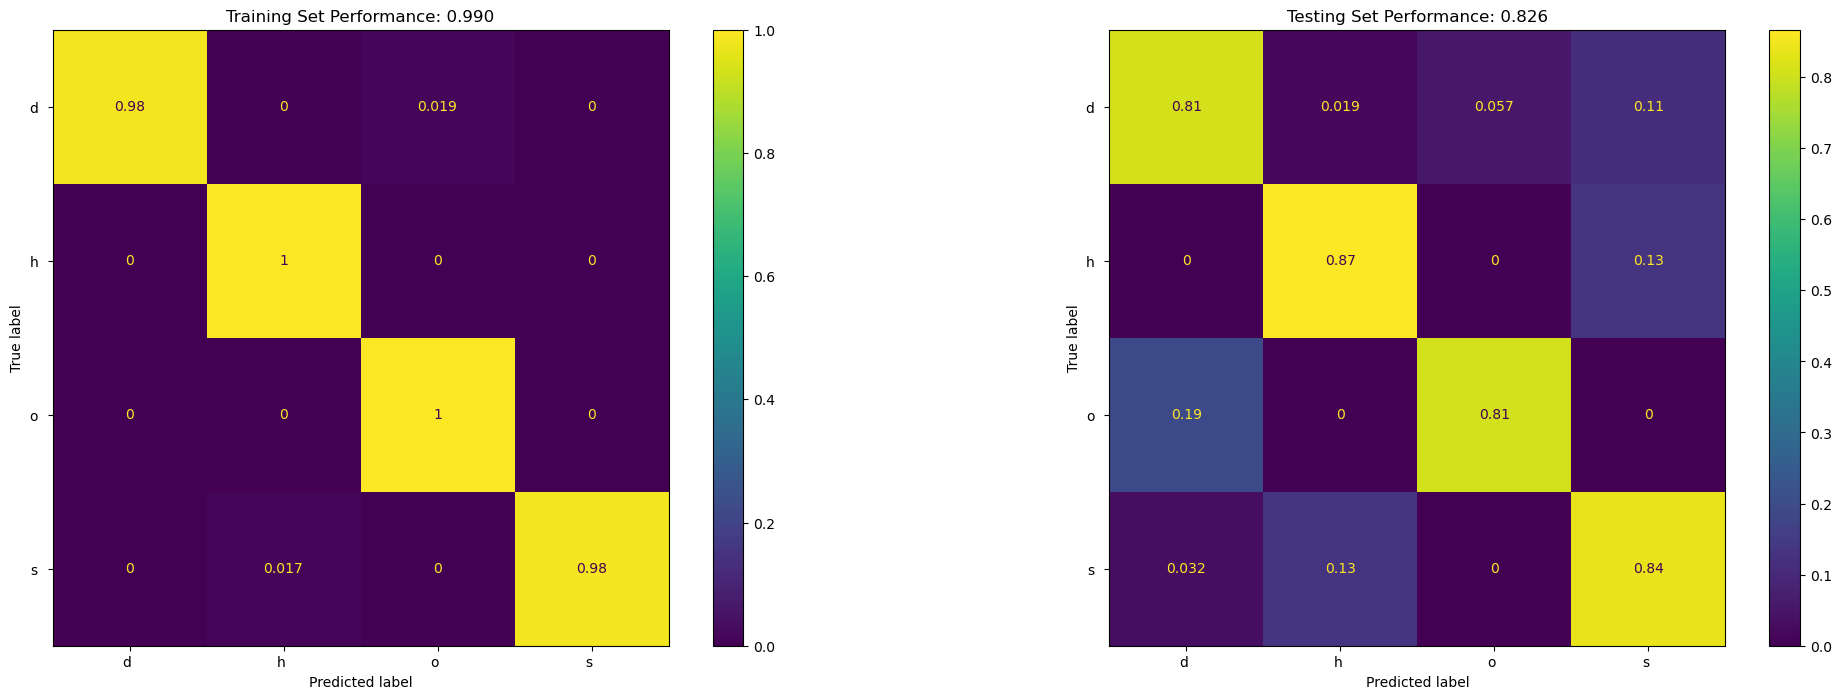

In [14]:
svm = SVC()
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

Pretty poor fit, but we know there is a huge class imbalance. Lets try and fix that a tad by applying class weights to increase the weight of undersampled classes.

As noted in the lecture example, with sklearn it's really easy to incorporate the class weights.

              precision    recall  f1-score   support

          d        0.86      0.81      0.83        53
          h        0.57      0.87      0.68        15
          o        0.90      0.84      0.87        31
          s        0.86      0.82      0.84        62

    accuracy                           0.83       161
   macro avg       0.80      0.83      0.81       161
weighted avg       0.84      0.83      0.83       161



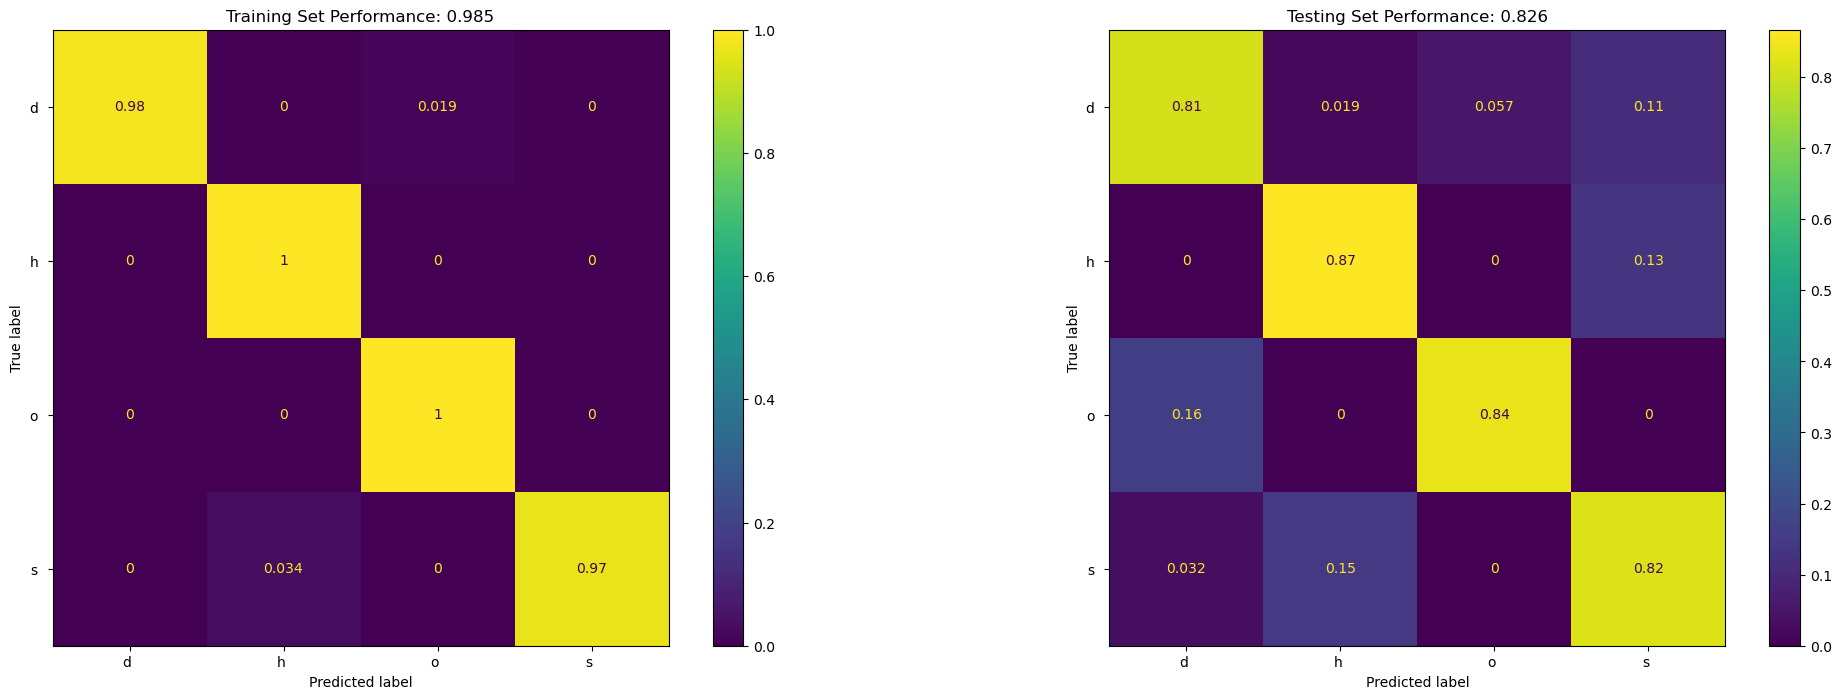

In [15]:
svm = SVC(class_weight='balanced')
svm.fit(X_train, Y_train)
eval_model(svm, X_train, Y_train, X_test, Y_test)

              precision    recall  f1-score   support

          d        0.88      0.81      0.84        53
          h        0.57      0.87      0.68        15
          o        0.92      0.77      0.84        31
          s        0.84      0.85      0.85        62

    accuracy                           0.83       161
   macro avg       0.80      0.83      0.80       161
weighted avg       0.84      0.83      0.83       161



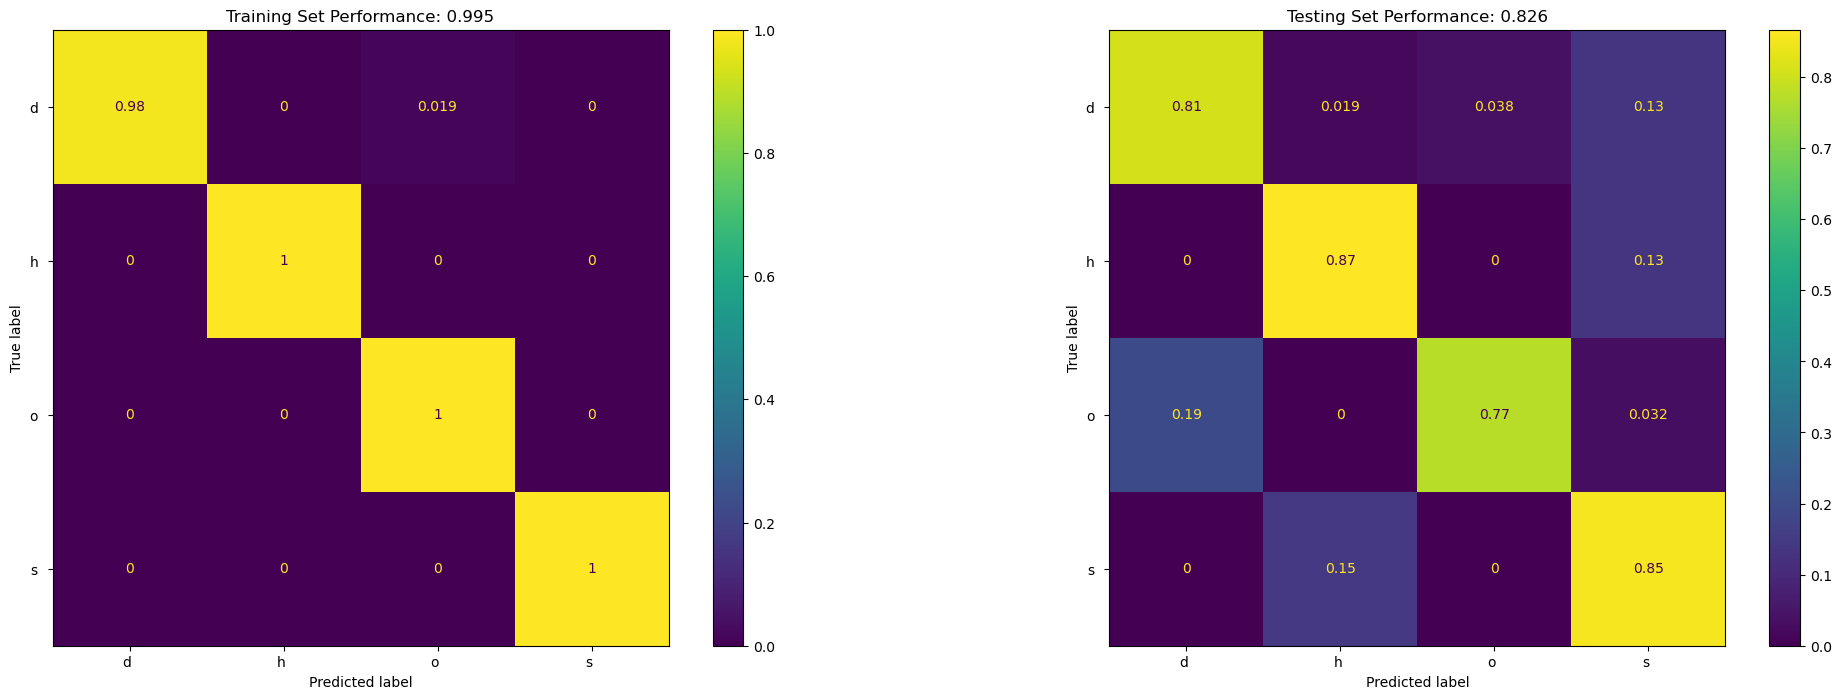

In [16]:
onevsall_svm = OneVsRestClassifier(SVC(class_weight='balanced'))
onevsall_svm.fit(X_train, Y_train)
eval_model(onevsall_svm, X_train, Y_train, X_test, Y_test)

In [17]:
param_grid = { 
    'C': [0.1, 1, 10, 100],
    'kernel' : ['linear', 'rbf', 'poly'],
    'gamma' :[0.1, 0.01, 0.001],
    'degree' : [4, 5, 6, 7, 8]
}
svm = SVC(class_weight='balanced')
grid_search = GridSearchCV(svm, param_grid)
grid_search.fit(X_val, Y_val)
grid_search.cv_results_

{'mean_fit_time': array([0.01179619, 0.0075892 , 0.0087976 , 0.01454535, 0.00761294,
        0.00948019, 0.015027  , 0.00857134, 0.00883641, 0.01108842,
        0.0076395 , 0.00748696, 0.01237807, 0.00643477, 0.00755119,
        0.01111498, 0.00665827, 0.00771074, 0.0114747 , 0.0079936 ,
        0.00759559, 0.01160059, 0.00833473, 0.00763159, 0.01204071,
        0.00749111, 0.00734873, 0.01122427, 0.00849953, 0.008148  ,
        0.01105022, 0.0065176 , 0.00688896, 0.01153059, 0.00747695,
        0.00726085, 0.01113296, 0.00791426, 0.00726991, 0.01340084,
        0.00687609, 0.00684428, 0.01191087, 0.00749774, 0.00679545,
        0.03979192, 0.007903  , 0.00859389, 0.0301065 , 0.00818563,
        0.00900612, 0.03794665, 0.00603042, 0.00864606, 0.03732591,
        0.00847964, 0.00776291, 0.03532057, 0.00754209, 0.00851717,
        0.05473671, 0.00652633, 0.00872445, 0.04050207, 0.00821853,
        0.00719738, 0.04089127, 0.01064162, 0.00952773, 0.03914971,
        0.00732269, 0.00747972,

{'C': 0.1, 'degree': 6, 'gamma': 0.1, 'kernel': 'poly'}
              precision    recall  f1-score   support

          d        1.00      0.40      0.57        53
          h        1.00      0.33      0.50        15
          o        1.00      0.81      0.89        31
          s        0.56      1.00      0.72        62

    accuracy                           0.70       161
   macro avg       0.89      0.63      0.67       161
weighted avg       0.83      0.70      0.68       161



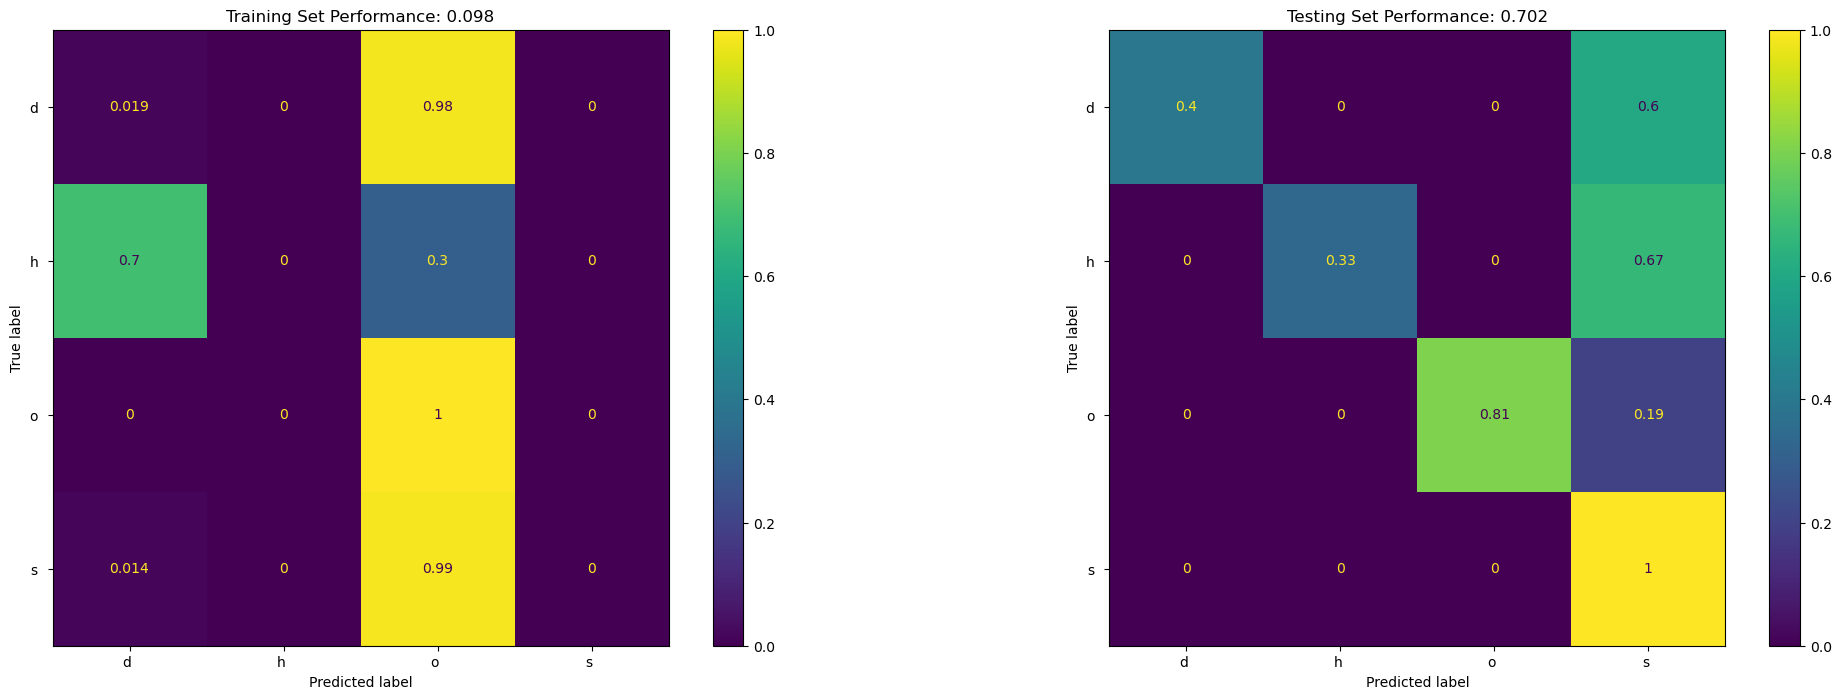

In [18]:
best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
params = grid_search.cv_results_['params'][best_system]
print(params)
svm = SVC().set_params(**params)
svm.fit(X_test, Y_test)
eval_model(svm, X_val, Y_val, X_test, Y_test)

It's fair to say, this goes badly. We have massive class imbalance as seen above, so need to reduce the 'NumNeighbors' parameter to increase the chance of being able to get these rare classes right. If we have this too big, then by virtue of a lack of sample points, these rare classes will always be classified as something else simply becuase there are not enough points.

## CKNN

              precision    recall  f1-score   support

          d        0.75      1.00      0.85        53
          h        0.76      0.87      0.81        15
          o        1.00      0.74      0.85        31
          s        1.00      0.81      0.89        62

    accuracy                           0.86       161
   macro avg       0.88      0.85      0.85       161
weighted avg       0.89      0.86      0.86       161



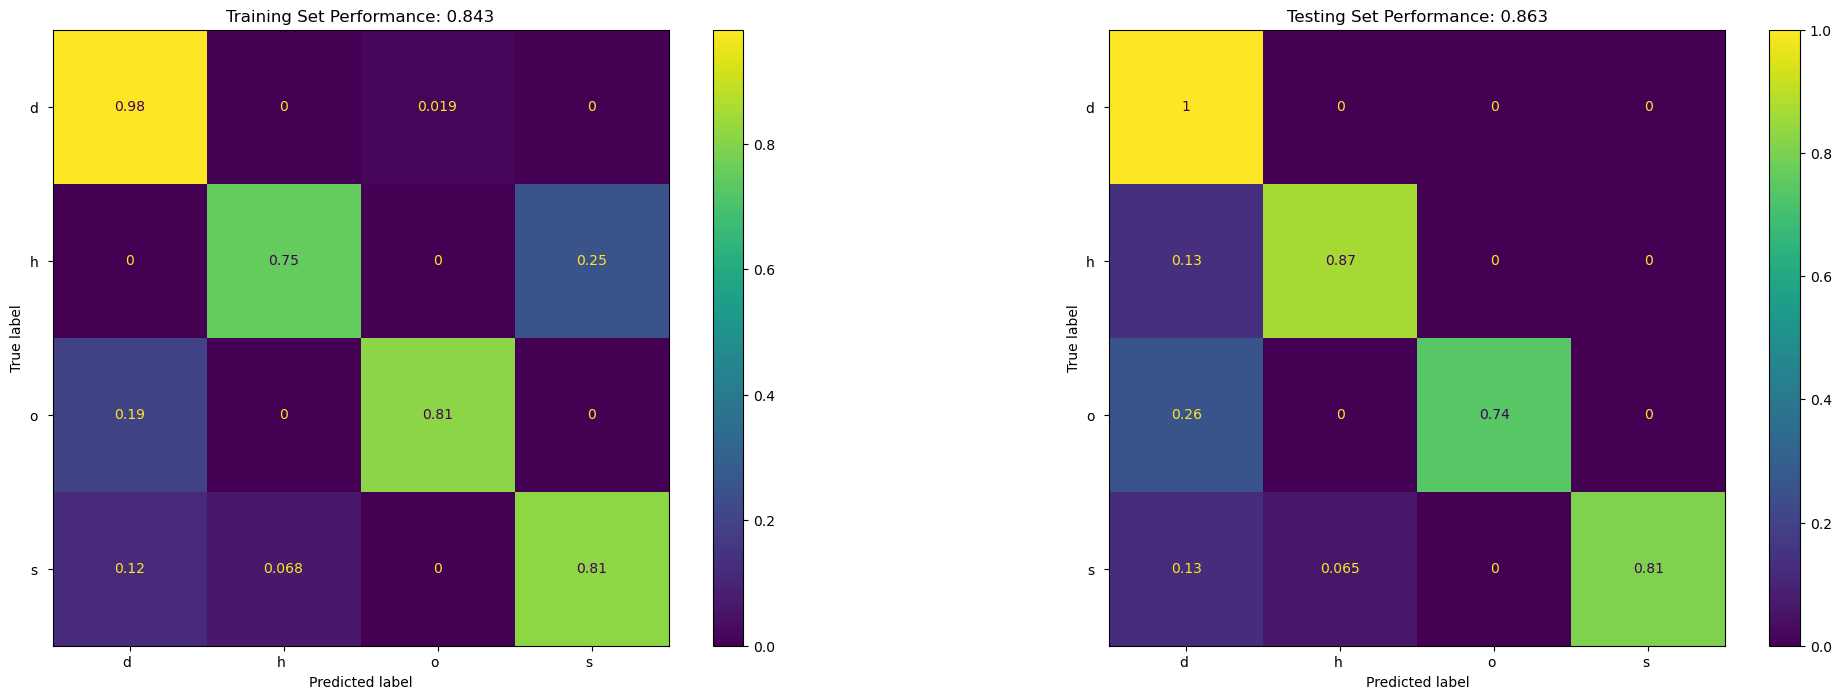

In [19]:
cknn = KNeighborsClassifier(n_neighbors=2)
cknn.fit(X_test, Y_test)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

In [20]:
knn = KNeighborsClassifier()
k_range = list(range(1, 64))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_val, Y_val)

print(grid_search.best_params_)

Fitting 10 folds for each of 63 candidates, totalling 630 fits
{'n_neighbors': 3}


              precision    recall  f1-score   support

          d        0.88      0.94      0.91        53
          h        0.92      0.80      0.86        15
          o        0.96      0.81      0.88        31
          s        0.91      0.95      0.93        62

    accuracy                           0.91       161
   macro avg       0.92      0.88      0.89       161
weighted avg       0.91      0.91      0.91       161



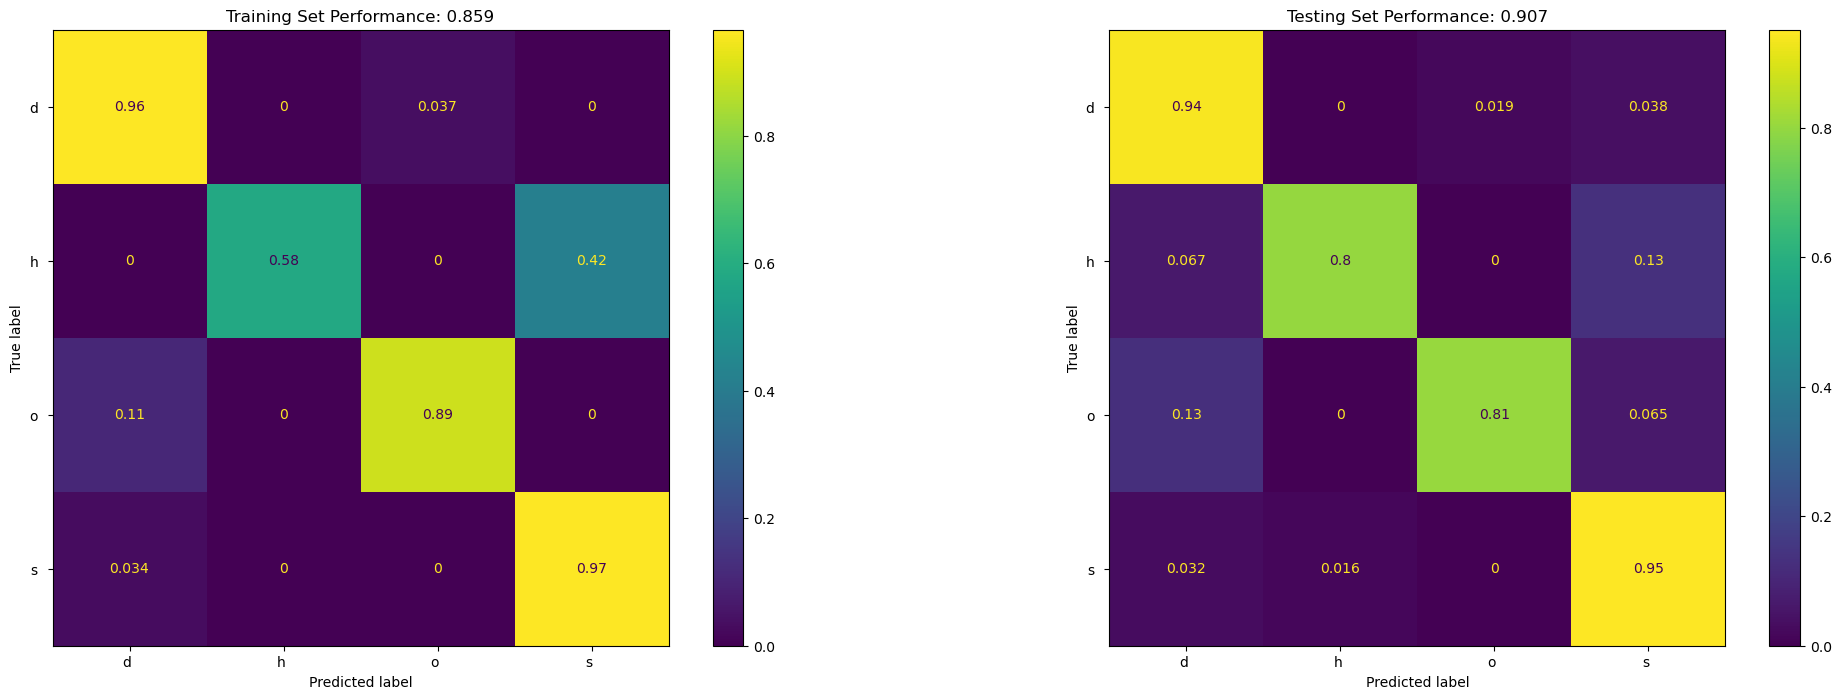

In [21]:
cknn = KNeighborsClassifier(n_neighbors=3)
cknn.fit(X_test, Y_test)
eval_model(cknn, X_train, Y_train, X_test, Y_test)

C:\Users\ryani\miniconda3\envs\cab420\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ryani\miniconda3\envs\cab420\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ryani\miniconda3\envs\cab420\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          d        0.00      0.00      0.00        53
          h        0.00      0.00      0.00        15
          o        0.00      0.00      0.00        31
          s        0.39      1.00      0.56        62

    accuracy                           0.39       161
   macro avg       0.10      0.25      0.14       161
weighted avg       0.15      0.39      0.21       161



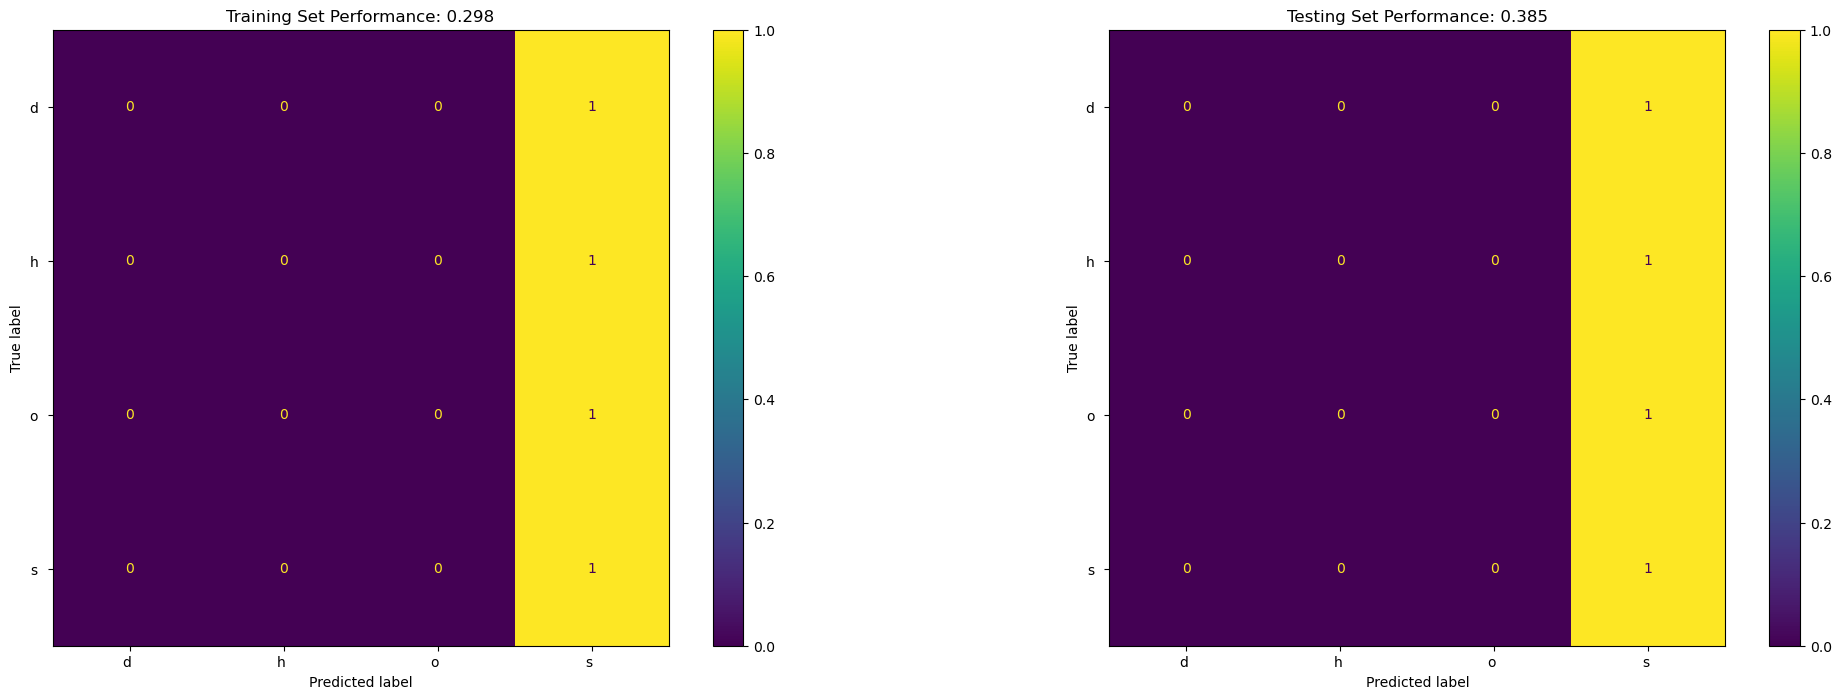

In [22]:
cknn = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn.fit(X_val, Y_val)
eval_model(cknn, X_train, Y_train, X_test, Y_test)